# 04 - Visualization

Generate publication-quality figures for metric evaluation results.

In [1]:
import sys
from pathlib import Path

project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr

from src.data_loader import load_all_datasets, get_metric_names
from src.statistics import compute_significance_analysis
from src.visualization import plot_williams_heatmap, plot_combined_heatmaps

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10

results_dir = project_root / 'results'
figures_dir = results_dir / 'figures'
figures_dir.mkdir(parents=True, exist_ok=True)

ALPHA = 0.05

print('Setup complete!')

Setup complete!


## 1. Load Data

In [2]:
datasets = load_all_datasets()

Loading all datasets...

ARTS:
  ARTS94: 94 samples, 10 metrics
  ARTS300: 300 samples, 10 metrics
  ARTS3k: 2999 samples, 10 metrics

LR-ARTS (Length-Residualized):
  LR-ARTS94: 94 samples, 10 metrics [LENGTH-RESIDUALIZED]
  LR-ARTS300: 300 samples, 10 metrics [LENGTH-RESIDUALIZED]
  LR-ARTS3k: 2999 samples, 10 metrics [LENGTH-RESIDUALIZED]

SDA:
  SDA: 600 samples, 26 metrics

Human-annotated:
  ST-sent: 1620 samples, 26 metrics, scale (1, 7)
  ST-para: 271 samples, 26 metrics, scale (1, 7)
  D-Wiki: 601 samples, 26 metrics, scale (1, 5)


## 2. Compute Correlations

In [3]:
def compute_correlations(data):
    """Compute correlations for all metrics in a dataset."""
    human = data['human_scores']
    metrics = data['metric_scores']
    
    results = []
    for name, scores in metrics.items():
        if name == 'human':
            continue
        mask = ~(np.isnan(human) | np.isnan(scores))
        if mask.sum() < 10:
            continue
        r, p = pearsonr(human[mask], scores[mask])
        results.append({'Metric': name, 'Pearson': r, 'p_value': p})
    
    df = pd.DataFrame(results)
    return df.sort_values('Pearson', ascending=False).reset_index(drop=True)

correlations = {}
for name, data in datasets.items():
    correlations[name] = compute_correlations(data)
    print(f'{name}: {len(correlations[name])} metrics')

ARTS94: 10 metrics
ARTS300: 10 metrics
ARTS3k: 10 metrics
LR-ARTS94: 10 metrics
LR-ARTS300: 10 metrics
LR-ARTS3k: 10 metrics
SDA: 26 metrics
ST-sent: 26 metrics
ST-para: 26 metrics
D-Wiki: 26 metrics


## 3. Figure 1: Correlation Heatmap (All Datasets)

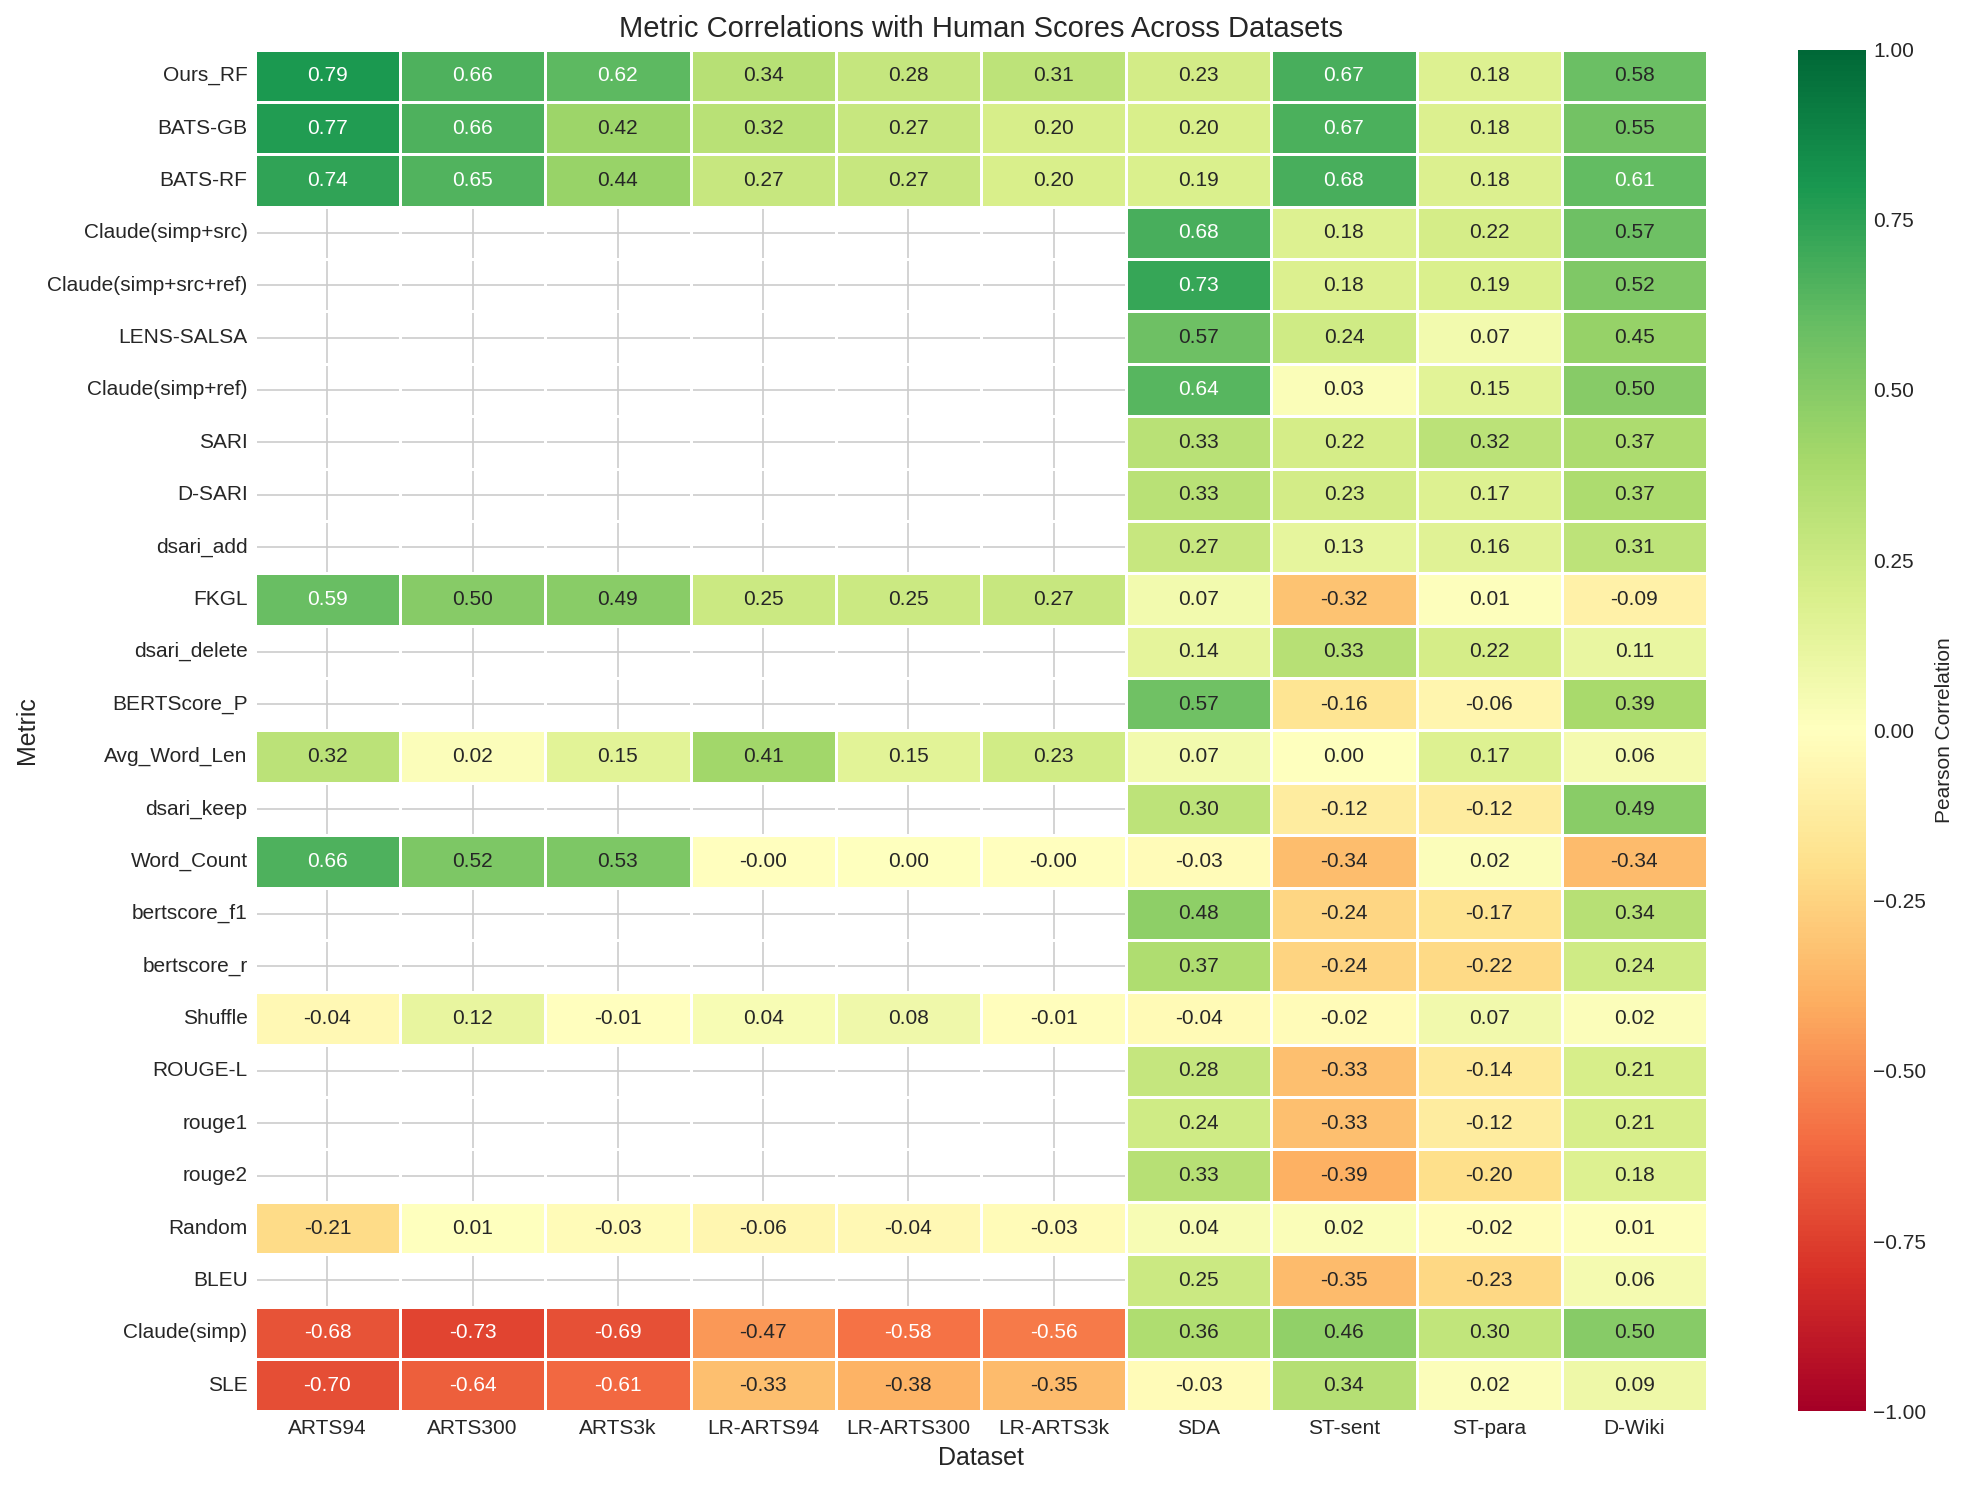

Saved: fig1_correlation_heatmap.png/pdf


In [4]:
# Build comparison matrix
all_metrics = set()
for df in correlations.values():
    all_metrics.update(df['Metric'].tolist())

comparison_data = {}
for dataset_name, df in correlations.items():
    comparison_data[dataset_name] = dict(zip(df['Metric'], df['Pearson']))

comparison_df = pd.DataFrame(comparison_data)

# Order columns
col_order = ['ARTS94', 'ARTS300', 'ARTS3k', 'LR-ARTS94', 'LR-ARTS300', 'LR-ARTS3k', 'SDA', 'ST-sent', 'ST-para', 'D-Wiki']
col_order = [c for c in col_order if c in comparison_df.columns]
comparison_df = comparison_df[col_order]

# Sort by average
comparison_df['avg'] = comparison_df.mean(axis=1)
comparison_df = comparison_df.sort_values('avg', ascending=False).drop('avg', axis=1)

# Plot
fig, ax = plt.subplots(figsize=(14, 10))

sns.heatmap(
    comparison_df,
    annot=True,
    fmt='.2f',
    cmap='RdYlGn',
    center=0,
    vmin=-1,
    vmax=1,
    ax=ax,
    cbar_kws={'label': 'Pearson Correlation'},
    linewidths=0.5,
)

ax.set_title('Metric Correlations with Human Scores Across Datasets', fontsize=14)
ax.set_xlabel('Dataset', fontsize=12)
ax.set_ylabel('Metric', fontsize=12)

plt.tight_layout()
plt.savefig(figures_dir / 'fig1_correlation_heatmap.png', bbox_inches='tight')
plt.savefig(figures_dir / 'fig1_correlation_heatmap.pdf', bbox_inches='tight')
plt.show()
print('Saved: fig1_correlation_heatmap.png/pdf')

## 4. Figure 2: Bar Chart - Top Metrics by Average Correlation

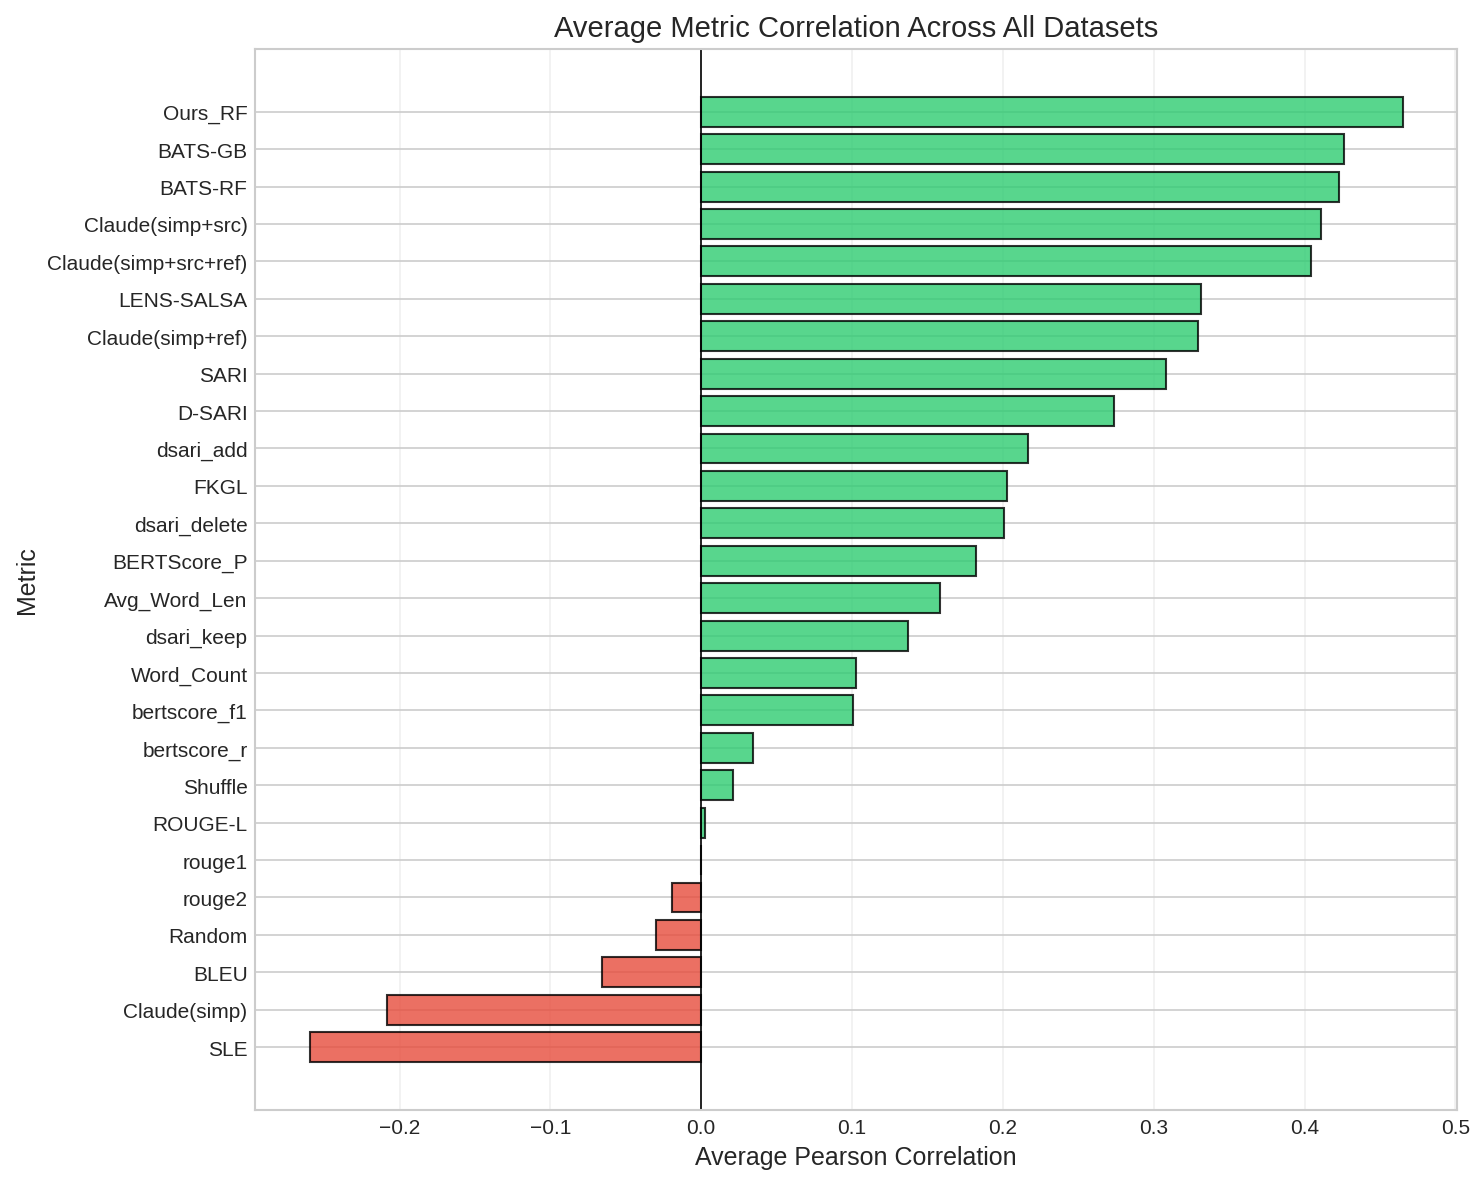

Saved: fig2_average_correlation.png/pdf


In [5]:
# Compute average correlation
avg_corr = comparison_df.mean(axis=1).sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(10, 8))

colors = ['#2ecc71' if v > 0 else '#e74c3c' for v in avg_corr]
ax.barh(avg_corr.index, avg_corr.values, color=colors, edgecolor='black', alpha=0.8)

ax.axvline(0, color='black', linewidth=0.8)
ax.set_xlabel('Average Pearson Correlation', fontsize=12)
ax.set_ylabel('Metric', fontsize=12)
ax.set_title('Average Metric Correlation Across All Datasets', fontsize=14)
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(figures_dir / 'fig2_average_correlation.png', bbox_inches='tight')
plt.savefig(figures_dir / 'fig2_average_correlation.pdf', bbox_inches='tight')
plt.show()
print('Saved: fig2_average_correlation.png/pdf')

## 5. Figure 3: Williams Significance Matrix (All Datasets)

The Williams test compares dependent correlations to determine if one metric is significantly better than another. Cell (i,j) shows the p-value for testing whether metric i has a significantly higher correlation with human scores than metric j.

- **Green cells**: Highly significant (p close to 0)
- **Orange cells**: Less significant (p approaching 0.05)
- **Empty cells**: Not significant (p >= 0.05)

In [6]:
# Compute Williams significance for all datasets
significance_results = {}

for dataset_name, data in datasets.items():
    human = data['human_scores']
    metrics = data['metric_scores']
    
    # Prepare metric scores (exclude 'human' key if present)
    metric_scores = {k: v for k, v in metrics.items() if k != 'human'}
    
    # Handle NaN values
    valid_mask = ~np.isnan(human)
    human_clean = human[valid_mask]
    metric_scores_clean = {k: v[valid_mask] for k, v in metric_scores.items()}
    
    # Compute significance analysis
    result = compute_significance_analysis(
        metric_scores_clean,
        human_clean,
        method='pearson',
        alpha=ALPHA,
    )
    
    significance_results[dataset_name] = result
    print(f'{dataset_name}: {len(result["top_metrics"])} top metrics - {result["top_metrics"]}')

ARTS94: 2 top metrics - ['Ours_RF', 'BATS-GB']
ARTS300: 1 top metrics - ['Claude(simp)']
ARTS3k: 1 top metrics - ['Claude(simp)']
LR-ARTS94: 2 top metrics - ['Claude(simp)', 'Avg_Word_Len']
LR-ARTS300: 1 top metrics - ['Claude(simp)']
LR-ARTS3k: 1 top metrics - ['Claude(simp)']
SDA: 1 top metrics - ['Claude(simp+src+ref)']
ST-sent: 3 top metrics - ['BATS-RF', 'Ours_RF', 'BATS-GB']
ST-para: 3 top metrics - ['SARI', 'Claude(simp)', 'BLEU']
D-Wiki: 2 top metrics - ['BATS-RF', 'Claude(simp+src)']


SDA: 1 top metrics - ['Claude(simp+src+ref)']


ST-sent: 3 top metrics - ['BATS-RF', 'Ours_RF', 'BATS-GB']
ST-para: 3 top metrics - ['SARI', 'Claude(simp)', 'BLEU']


D-Wiki: 2 top metrics - ['BATS-RF', 'Claude(simp+src)']


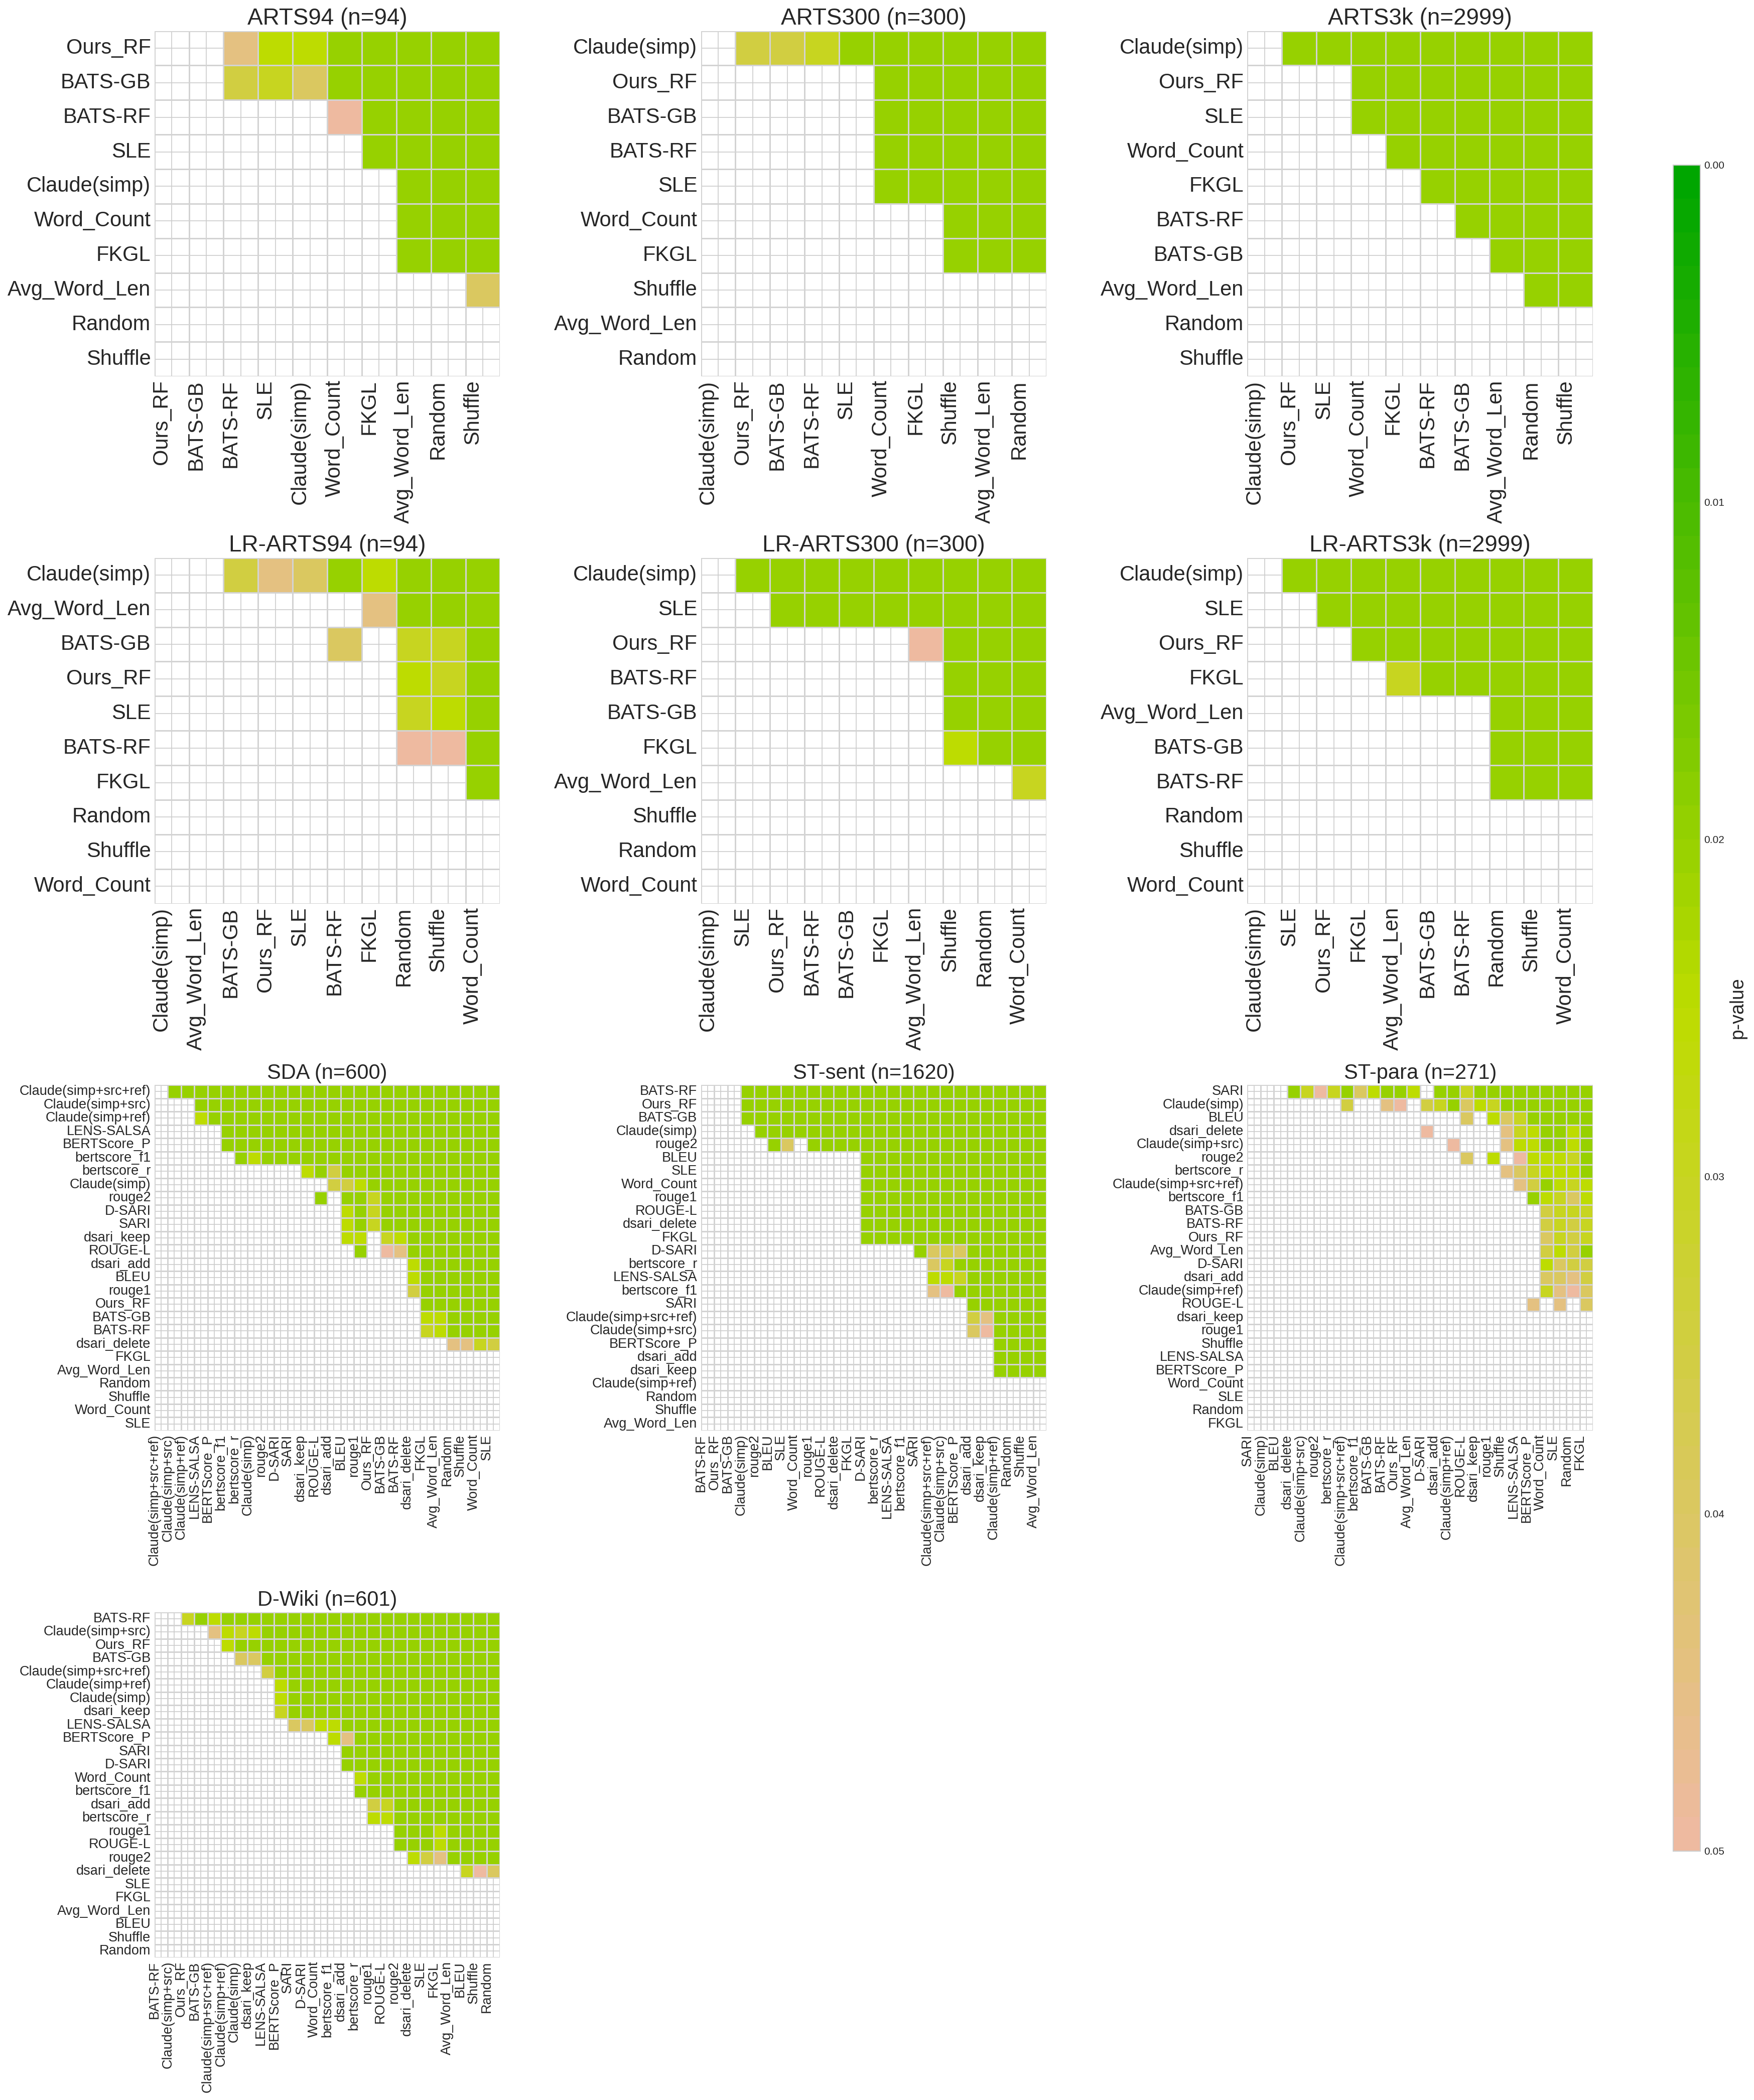

Saved: fig3_williams_all_datasets.png/pdf


In [7]:
# Plot combined Williams significance heatmaps for all datasets
# Uses proper formatting: green-to-orange palette, only significant values, inverted colorbar
fig = plot_combined_heatmaps(
    significance_results,
    n_cols=3,
    figsize_per_plot=(8, 7),
    alpha=ALPHA,
    sort_by_wins=True,  # Best metrics at top
    save_path=figures_dir / 'fig3_williams_all_datasets.png',
)
plt.savefig(figures_dir / 'fig3_williams_all_datasets.pdf', bbox_inches='tight')
plt.show()
print('Saved: fig3_williams_all_datasets.png/pdf')

## 6. Figure 4: Human Score Distributions

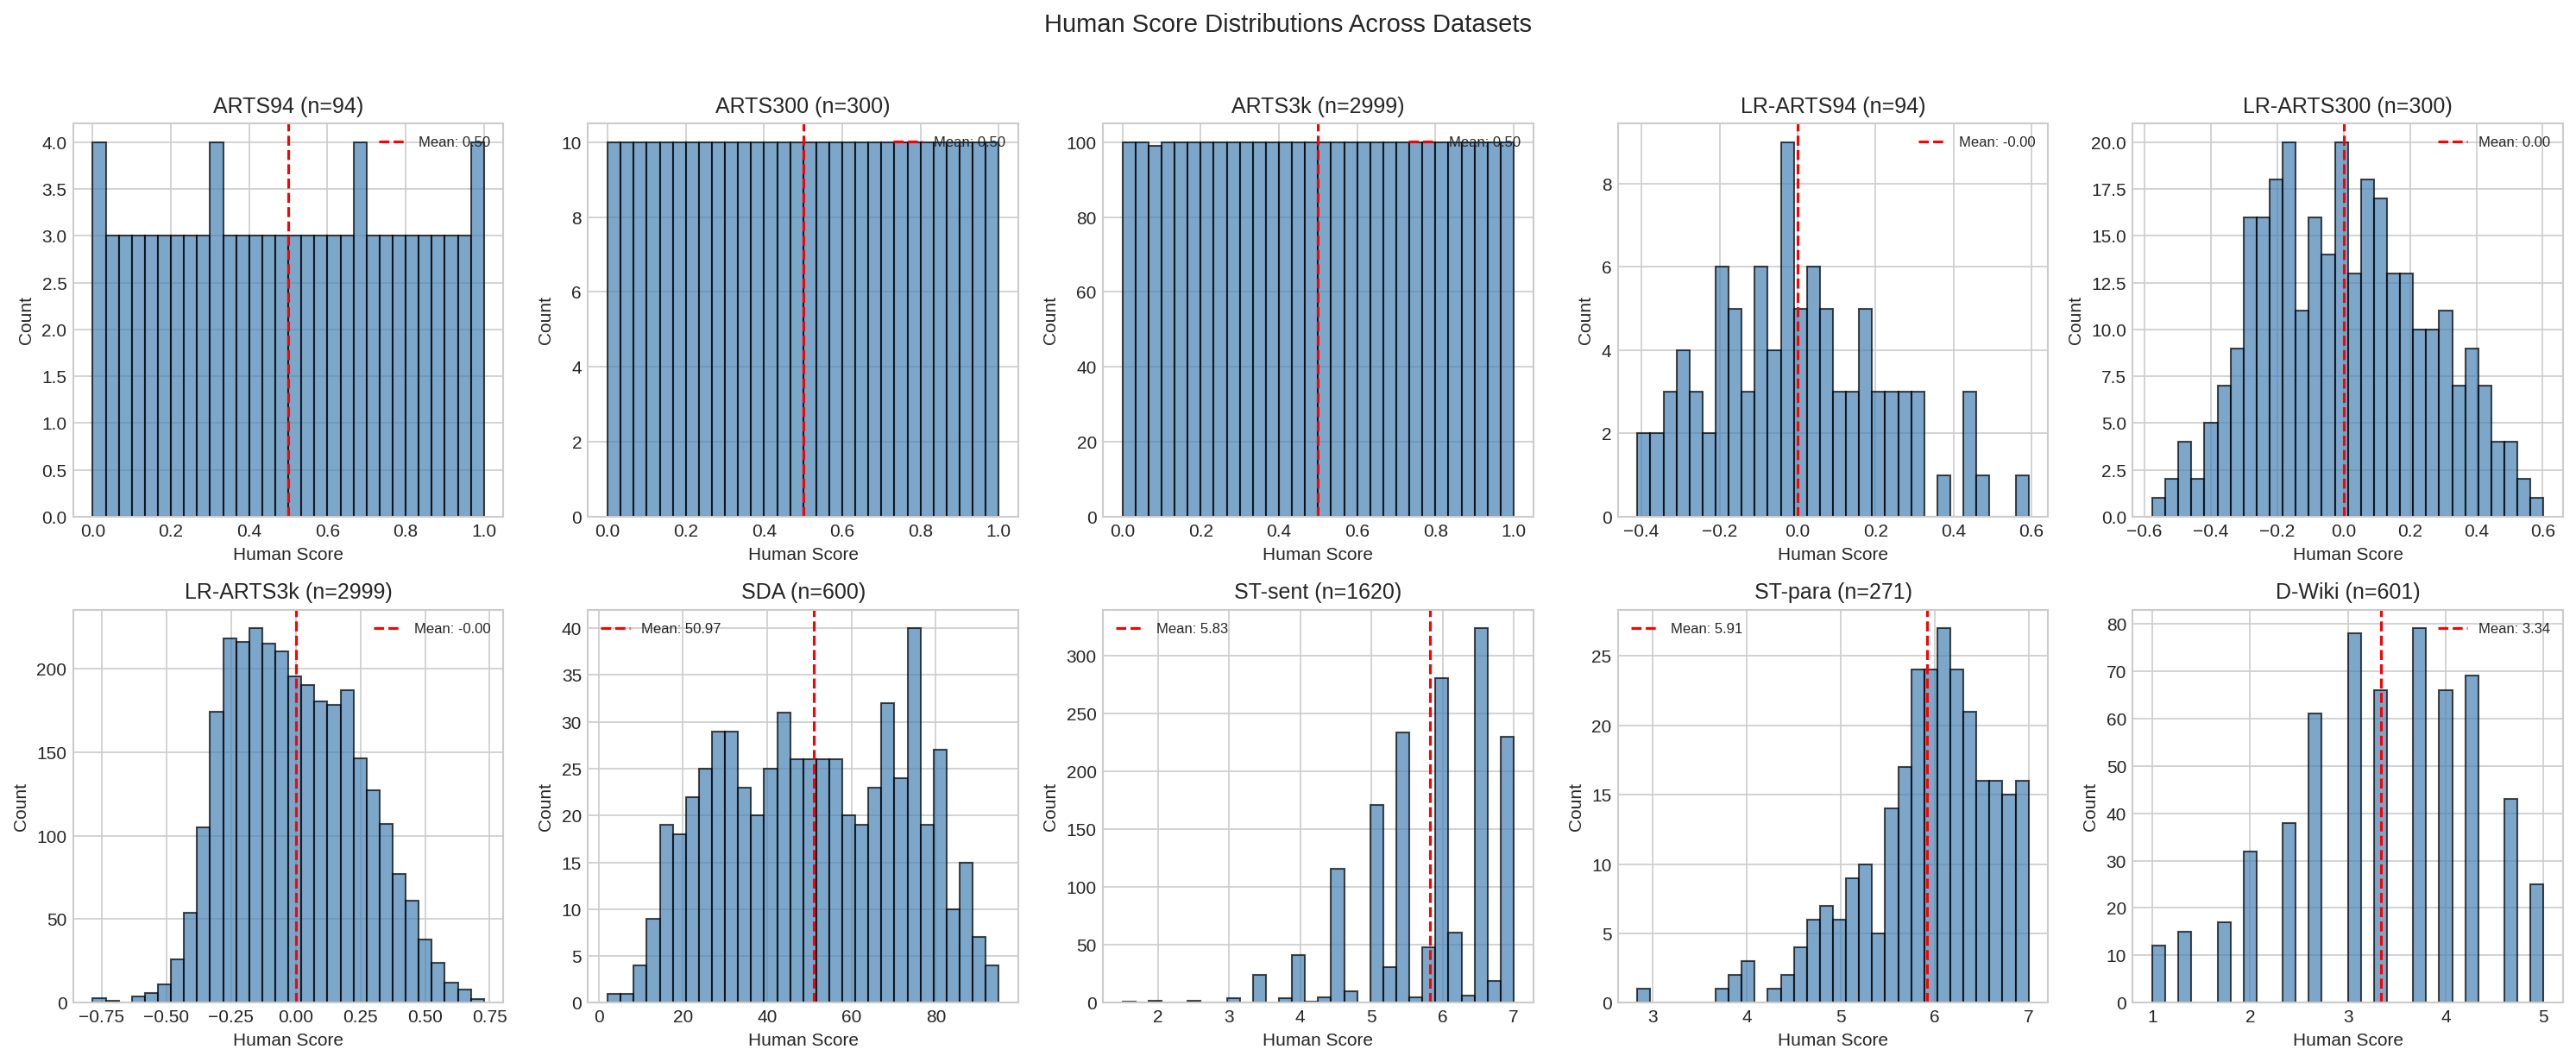

Saved: fig4_score_distributions.png/pdf


In [8]:
# Dynamic grid for human score distributions
dataset_order = ['ARTS94', 'ARTS300', 'ARTS3k', 'LR-ARTS94', 'LR-ARTS300', 'LR-ARTS3k', 'SDA', 'ST-sent', 'ST-para', 'D-Wiki']
dataset_order = [d for d in dataset_order if d in datasets]

n_datasets = len(dataset_order)
n_cols = 5
n_rows = (n_datasets + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows))
axes = axes.flatten()

for i, name in enumerate(dataset_order):
    ax = axes[i]
    data = datasets[name]
    human = data['human_scores']
    
    ax.hist(human[~np.isnan(human)], bins=30, edgecolor='black', alpha=0.7, color='steelblue')
    ax.axvline(np.nanmean(human), color='red', linestyle='--', label=f'Mean: {np.nanmean(human):.2f}')
    ax.set_title(f'{name} (n={data["n_samples"]})')
    ax.set_xlabel('Human Score')
    ax.set_ylabel('Count')
    ax.legend(fontsize=8)

# Hide unused subplots
for i in range(len(dataset_order), len(axes)):
    axes[i].set_visible(False)

plt.suptitle('Human Score Distributions Across Datasets', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig(figures_dir / 'fig4_score_distributions.png', bbox_inches='tight')
plt.savefig(figures_dir / 'fig4_score_distributions.pdf', bbox_inches='tight')
plt.show()
print('Saved: fig4_score_distributions.png/pdf')

## 7. Figure 5: Scatter Plots - Best Metrics vs Human

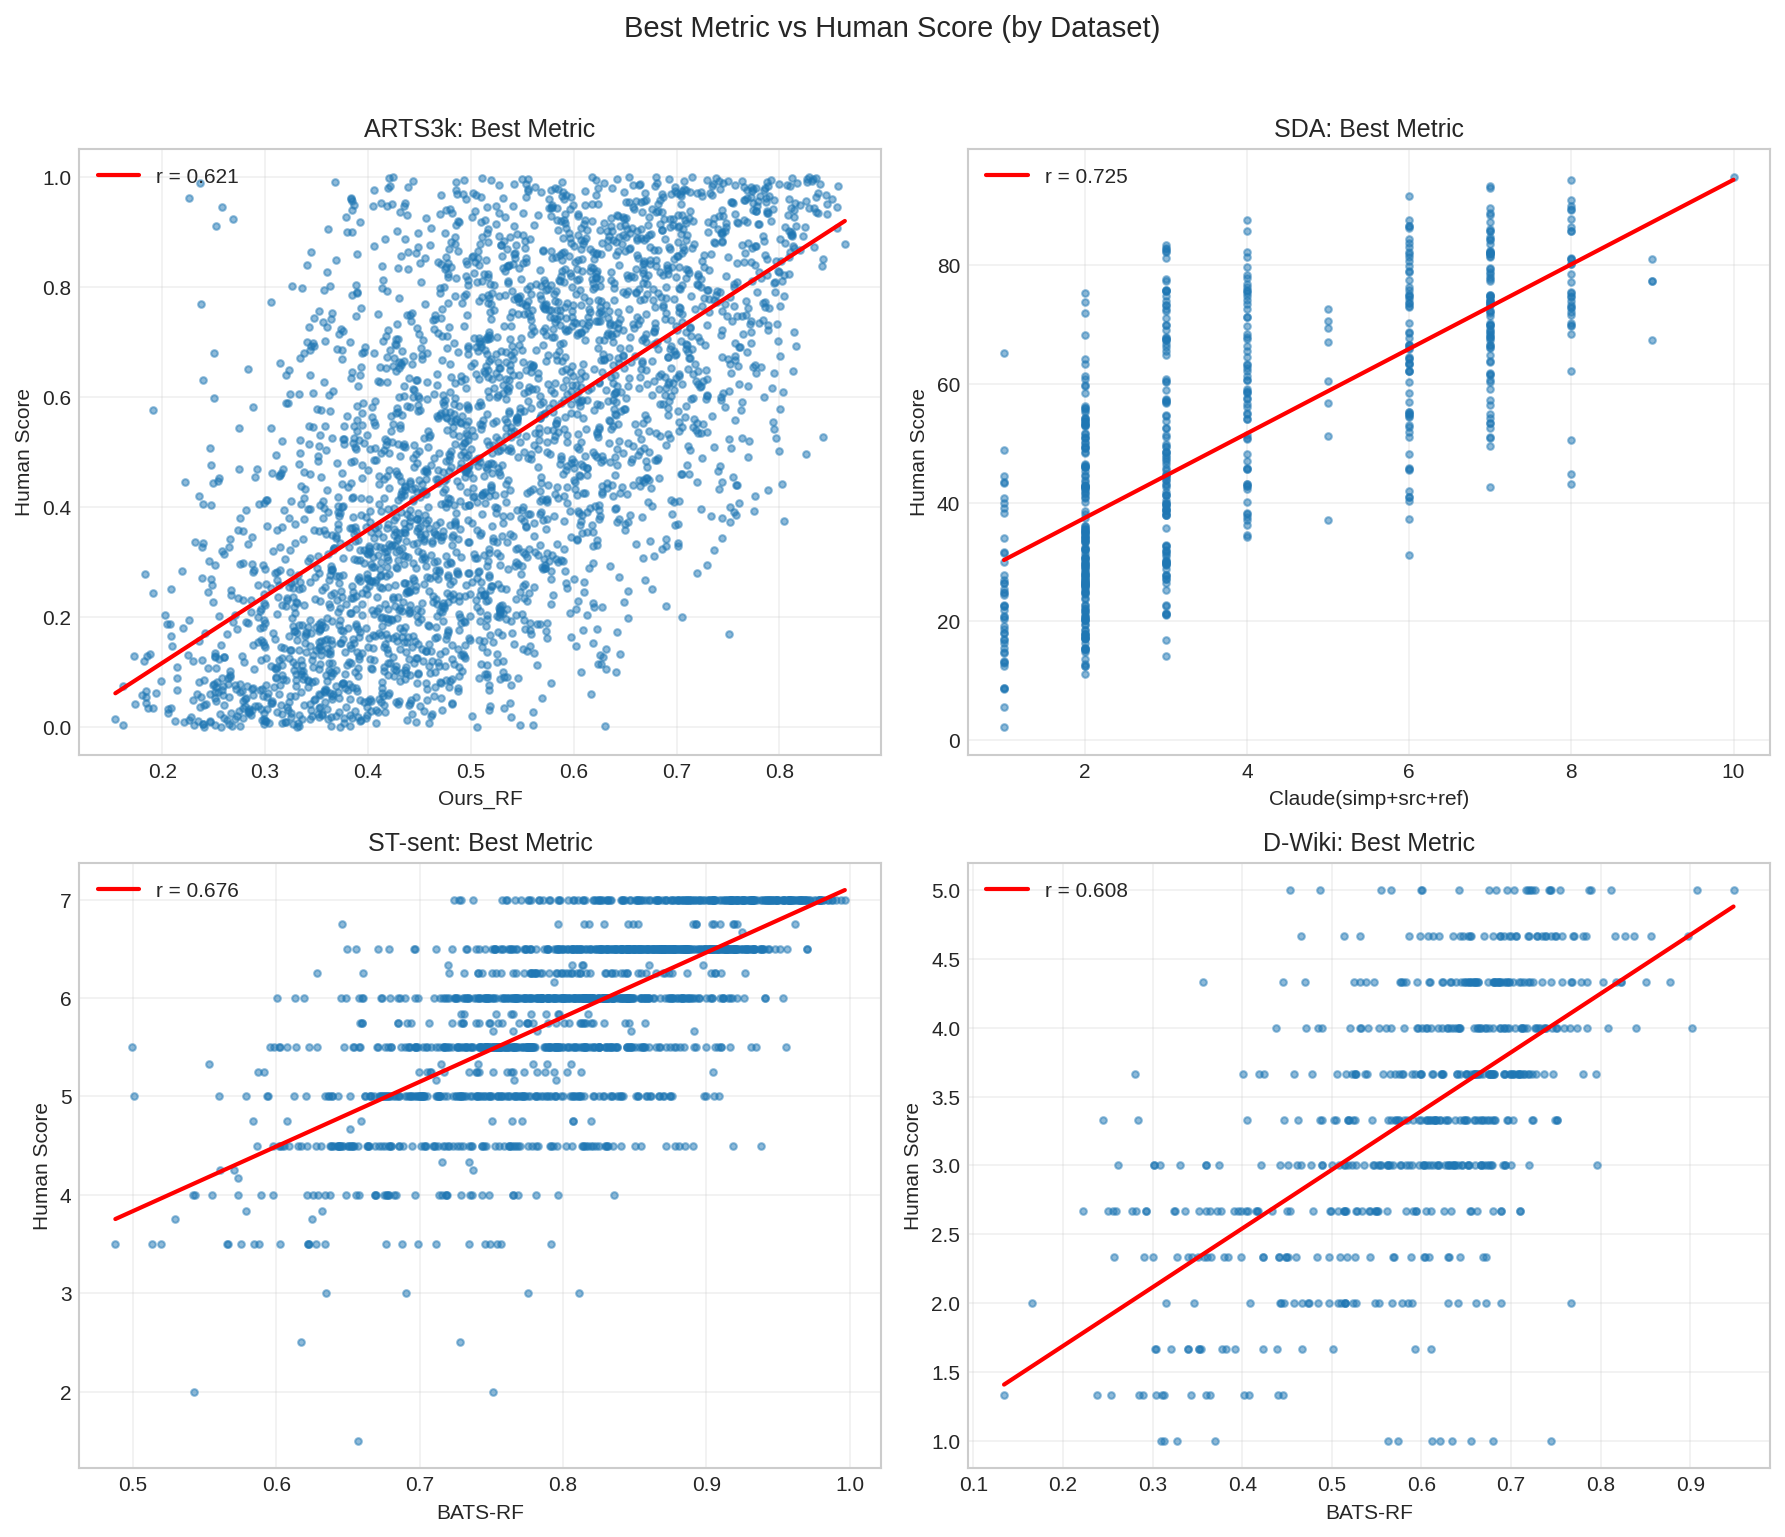

Saved: fig5_scatter_best_metrics.png/pdf


In [9]:
# Select datasets with most metrics
selected = ['ARTS3k', 'SDA', 'ST-sent', 'D-Wiki']

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, name in enumerate(selected):
    ax = axes[i]
    data = datasets[name]
    human = data['human_scores']
    metrics = data['metric_scores']
    
    # Get best metric
    best_metric = correlations[name].iloc[0]['Metric']
    best_r = correlations[name].iloc[0]['Pearson']
    scores = metrics[best_metric]
    
    mask = ~(np.isnan(human) | np.isnan(scores))
    ax.scatter(scores[mask], human[mask], alpha=0.5, s=10)
    
    # Regression line
    z = np.polyfit(scores[mask], human[mask], 1)
    p = np.poly1d(z)
    x_line = np.linspace(scores[mask].min(), scores[mask].max(), 100)
    ax.plot(x_line, p(x_line), 'r-', linewidth=2, label=f'r = {best_r:.3f}')
    
    ax.set_xlabel(best_metric, fontsize=10)
    ax.set_ylabel('Human Score', fontsize=10)
    ax.set_title(f'{name}: Best Metric', fontsize=12)
    ax.legend(loc='upper left')
    ax.grid(alpha=0.3)

plt.suptitle('Best Metric vs Human Score (by Dataset)', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig(figures_dir / 'fig5_scatter_best_metrics.png', bbox_inches='tight')
plt.savefig(figures_dir / 'fig5_scatter_best_metrics.pdf', bbox_inches='tight')
plt.show()
print('Saved: fig5_scatter_best_metrics.png/pdf')

## 8. Figure 6: Metric Correlation Variability

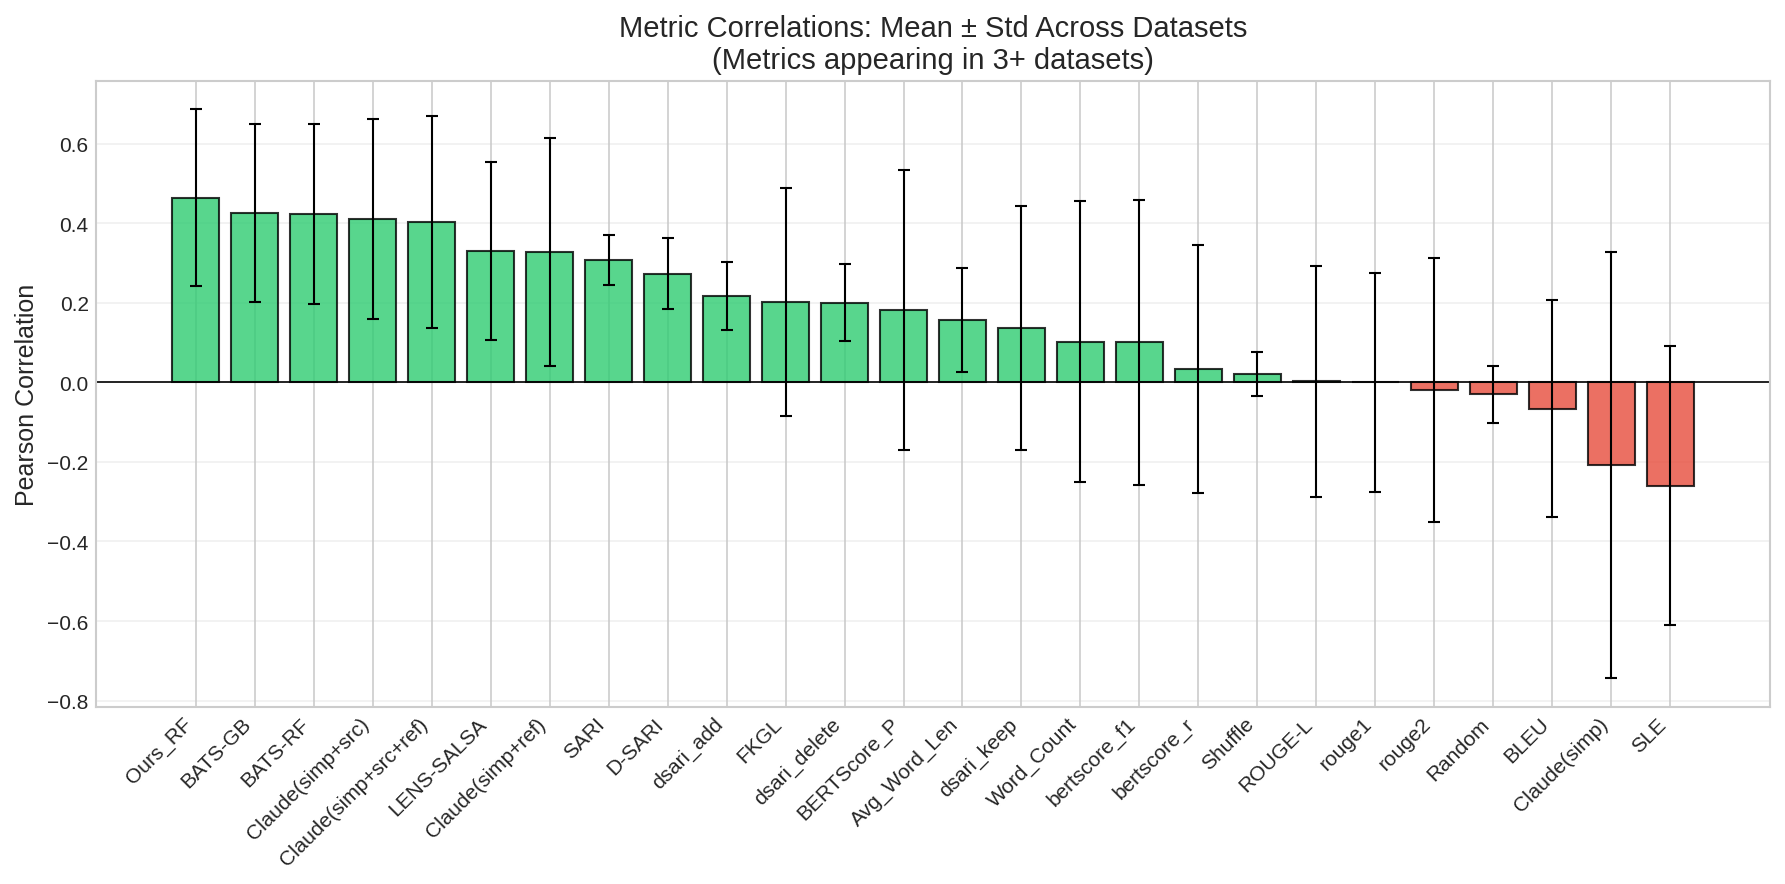

Saved: fig6_correlation_variability.png/pdf


In [10]:
# Show how metric correlations vary across datasets
fig, ax = plt.subplots(figsize=(12, 6))

# Metrics that appear in multiple datasets
metric_counts = comparison_df.notna().sum(axis=1)
common_metrics = metric_counts[metric_counts >= 3].index.tolist()

plot_data = comparison_df.loc[common_metrics]
mean_vals = plot_data.mean(axis=1)
std_vals = plot_data.std(axis=1)

# Sort by mean
sort_idx = mean_vals.sort_values(ascending=False).index
mean_vals = mean_vals[sort_idx]
std_vals = std_vals[sort_idx]

x = np.arange(len(mean_vals))
colors = ['#2ecc71' if v > 0 else '#e74c3c' for v in mean_vals]

ax.bar(x, mean_vals, yerr=std_vals, color=colors, edgecolor='black', 
       alpha=0.8, capsize=3, error_kw={'linewidth': 1})
ax.axhline(0, color='black', linewidth=0.8)
ax.set_xticks(x)
ax.set_xticklabels(mean_vals.index, rotation=45, ha='right')
ax.set_ylabel('Pearson Correlation', fontsize=12)
ax.set_title('Metric Correlations: Mean ± Std Across Datasets\n(Metrics appearing in 3+ datasets)', fontsize=14)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(figures_dir / 'fig6_correlation_variability.png', bbox_inches='tight')
plt.savefig(figures_dir / 'fig6_correlation_variability.pdf', bbox_inches='tight')
plt.show()
print('Saved: fig6_correlation_variability.png/pdf')

## 9. Summary

In [11]:
print('GENERATED FIGURES')
print('=' * 60)

figures = sorted(figures_dir.glob('fig*.png'))
for f in figures:
    print(f'  {f.name}')

print(f'\nTotal: {len(figures)} figures')

GENERATED FIGURES
  fig1_correlation_heatmap.png
  fig2_average_correlation.png
  fig3_williams_all_datasets.png
  fig3_williams_arts3k.png
  fig4_score_distributions.png
  fig5_scatter_best_metrics.png
  fig6_correlation_variability.png

Total: 7 figures
